In [11]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import torch.utils.data as Data
import matplotlib.pyplot as plt
import random

In [2]:
ratings = pd.read_csv('~/Data/clean_rating3.csv')

idx_to_animes = list(set(ratings['anime_id'].tolist()))
idx_to_users = list(set(ratings['user_id'].tolist()))
anime_to_idx = {anime: idx for idx, anime in enumerate(idx_to_animes)}
user_to_idx = {user: idx for idx, user in enumerate(idx_to_users)}
num_users, num_animes = len(idx_to_users), len(idx_to_animes)

# train_ratio = 0.9
# all_users = list(set(ratings.user_id))
# train_sample = random.sample(all_users, int(num_users * train_ratio))
# train_data = ratings[ratings.user_id.isin(train_sample)]
# test_data = list(set(all_users) - set(train_sample))
# print(train_data.shape)

data_ps = np.array(ratings.values.tolist())

from collections import defaultdict
user_item_dic, data, labels = defaultdict(list), [], []
for d in data_ps:
    user_item_dic[user_to_idx[d[0]]].append(anime_to_idx[d[1]])
    data.append([user_to_idx[d[0]], anime_to_idx[d[1]]])
    if d[2] != -1:
        labels.append(d[2] / 10)
    else:
        labels.append(0.5)

In [3]:
def get_hot_items():
    animes = pd.read_csv("~/Data/anime.csv")
    animes = animes[animes["anime_id"].isin(idx_to_animes)].loc[:, ["anime_id", "rating", "members"]].fillna(0)

    scalar = lambda x: (x - np.min(x)) / (np.max(x) - np.min(x))
    animes["rating_norm"] = animes[["rating"]].apply(scalar)
    animes["members_norm"] = animes[["members"]].apply(scalar)
    animes["weight"] = 0.6 * animes["rating_norm"] + 0.4 * animes["members_norm"]
    animes = animes.sort_values(by = "weight", ascending = False)
    
    return [anime_to_idx[i] for i in animes.anime_id.tolist()]

In [4]:
class NCFDataset(Data.Dataset):
    def __init__(self, data, labels, hot_items, user_item_dic):
        super(NCFDataset, self).__init__()
        self.data = data
        self.hot_items = hot_items
        self.labels = labels
        self.dic = user_item_dic
        
        
    def select_ng(self):
        ng_sample, users, n = [], set(list(zip(*self.data))[0]), 0
#         print(len(users))
        for user in users:
            for item in self.hot_items:
                if item not in self.dic[user]:
                    ng_sample.append([user, item])
                    n += 1
                if n == 10:
                    break
            n = 0
        
#         print(len(ng_sample))
        self.data += ng_sample
        self.labels += [0 for _ in range(len(ng_sample))]
        
    def __getitem__(self, idx):
        user, item = self.data[idx][0], self.data[idx][1]
        label = self.labels[idx]
        
        return user, item, label

    def __len__(self):
        return len(self.data)

In [5]:
batch_size = 5120
dataset = NCFDataset(data, labels, get_hot_items(), user_item_dic)
# dataset.select_ng()
data_iter = Data.DataLoader(dataset, batch_size = batch_size, shuffle = True)
for user, item, label in data_iter:
    print(user, item)
    break

tensor([3062, 1895, 2262,  ..., 1213, 1255, 2502]) tensor([2625, 7103, 6249,  ..., 7701,   43,  368])


In [6]:
class NCF(nn.Module):
    def __init__(self, num_users, num_items, model, factor_num = 8, num_layers = 3,
               MLP_model = None, GMF_model = None, alpha = 0.5, dropout = 0.5):
        super(NCF, self).__init__()
        self.MLP_model = MLP_model
        self.GMF_model = GMF_model
        self.alpha = alpha
        self.dropout = dropout
        self.user_embed_GMF = nn.Embedding(num_users, factor_num)
        self.item_embed_GMF = nn.Embedding(num_items, factor_num)
        self.user_embed_MLP = nn.Embedding(num_users, factor_num * (2 ** (num_layers - 1)))
        self.item_embed_MLP = nn.Embedding(num_items, factor_num * (2 ** (num_layers - 1)))
        self.sigmoid = nn.Sigmoid()

        self.MLP = nn.Sequential(
            nn.Dropout(p = self.dropout),
            nn.Linear(factor_num * (2 ** num_layers), factor_num * (2 ** (num_layers - 1))),
            nn.ReLU()
        )
        for layer in range(num_layers - 1, 0, -1):
            self.MLP.add_module('dropout' + str(num_layers - layer), nn.Dropout(p = self.dropout))
            self.MLP.add_module('linear' + str(num_layers - layer), nn.Linear(factor_num * (2 ** layer), factor_num * (2 ** (layer - 1))))
            self.MLP.add_module('relu' + str(num_layers - layer), nn.ReLU())

        self.model = model
        if self.model in ['GMF', 'MLP']:
            self.NeuMF = nn.Linear(factor_num, 1)
        else:
            self.NeuMF = nn.Linear(2 * factor_num, 1)

        self.__init_weights__()

    def __init_weights__(self):
        if self.model in ['GMF', 'MLP']:
            nn.init.normal_(self.user_embed_GMF.weight, std = 0.01)
            nn.init.normal_(self.item_embed_GMF.weight, std = 0.01)
            nn.init.normal_(self.user_embed_MLP.weight, std = 0.01)
            nn.init.normal_(self.item_embed_MLP.weight, std = 0.01)

            for layer in self.MLP:
                if isinstance(layer, nn.Linear):
                    nn.init.xavier_uniform_(layer.weight)
#                   nn.init.normal_(layer.weight, std = 0.01)

            nn.init.kaiming_uniform_(self.NeuMF.weight, a = 1, nonlinearity = 'sigmoid')
#             nn.init.normal_(self.NeuMF.weight, std = 0.01)

        elif self.GMF_model and self.MLP_model:
            self.user_embed_GMF.weight.data.copy_(self.GMF_model.user_embed_GMF.weight)
            self.item_embed_GMF.weight.data.copy_(self.GMF_model.item_embed_GMF.weight)
            self.user_embed_MLP.weight.data.copy_(self.MLP_model.user_embed_MLP.weight)
            self.item_embed_MLP.weight.data.copy_(self.MLP_model.item_embed_MLP.weight)

            for (m1, m2) in zip(self.MLP, self.MLP_model.MLP):
                if isinstance(m1, nn.Linear) and isinstance(m2, nn.Linear):
                    m1.weight.data.copy_(m2.weight)
                    m1.bias.data.copy_(m2.bias)

            NeuMF_weight = torch.cat((self.alpha * self.GMF_model.NeuMF.weight, (1 - self.alpha) * self.MLP_model.NeuMF.weight), 1)
            NeuMF_bias = self.GMF_model.NeuMF.bias + self.MLP_model.NeuMF.bias

            self.NeuMF.weight.data.copy_(NeuMF_weight)
            self.NeuMF.bias.data.copy_(NeuMF_bias)
            
    def forward(self, user, item):
        if self.model is 'GMF' or 'NCF':
            user_embed_GMF = self.user_embed_GMF(user)
            item_embed_GMF = self.item_embed_GMF(item)
            
#             print(user_embed_GMF.device, item_embed_GMF.decive)
            GMF_output = user_embed_GMF * item_embed_GMF

        if self.model is 'MLP' or 'NCF':
            user_embed_MLP = self.user_embed_MLP(user)
            item_embed_MLP = self.item_embed_MLP(item)

            MLP_input = torch.cat((user_embed_MLP, item_embed_MLP), 1)
            MLP_output = self.MLP(MLP_input)

        if self.model is 'NCF':
            output = self.NeuMF(torch.cat((MLP_output, GMF_output), 1))
        elif self.model is 'MLP':
            output = self.NeuMF(MLP_output)
        elif self.model is 'GMF':
            output = self.NeuMF(GMF_output)
            
        return self.sigmoid(output)

In [9]:
MLP_Loss, GMF_Loss, NCF_Loss = [], [], [] 
def train(net, num_epochs, lr, train_type = 'NCF'):
    print(train_type)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#     device = torch.device('cpu')
    print('train on', device)
    net = net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr = lr)
    loss = nn.MSELoss()
    for epoch in range(num_epochs):
        l_sum,n = 0, 0
        for user, item, label in data_iter:
            user = user.to(device)
            item = item.to(device)
            label = label.to(device)
            pred = net(user, item)
            l = loss(pred.view(label.shape), label.float())

            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            l_sum += l.cpu().item()
            n += 1
            
        if train_type == "MLP":
            MLP_Loss.append(l_sum / n)
        elif train_type == "GMF":
            GMF_Loss.append(l_sum / n)
        elif train_type == "NCF":
            NCF_Loss.append(l_sum / n)
            
        print(epoch + 1, l_sum / n)

In [10]:
MLP_net = NCF(num_users, num_animes, model = 'MLP')
train(MLP_net, 30, lr = 0.0001, train_type = 'MLP')

GMF_net = NCF(num_users, num_animes, model = 'GMF')
train(GMF_net, 30, lr = 0.0001, train_type = 'GMF')

NCF_net = NCF(num_users, num_animes, model = 'NCF', GMF_model = GMF_net, MLP_model = MLP_net)
train(NCF_net, 30, lr = 0.0001)

MLP
train on cuda
1 0.06789686378691896
2 0.02925719694125468
3 0.022706579355313287
4 0.020695380155186252
5 0.019672665309169172
6 0.01904538972406066
7 0.018540430624885012
8 0.018072231206014984
9 0.017709011614947655
10 0.017388225288416114
11 0.01712755694015005
12 0.016915661453477067
13 0.016754728238248404
14 0.016620849606644766
15 0.01652278969265833
16 0.016427897412338136
17 0.016362846680972355
18 0.016280676495226278
19 0.016221899456996265
20 0.01616760966867603
21 0.016120511651960167
22 0.016059109217448214
23 0.016019183712668108
24 0.015989748927585732
25 0.015943673274851924
26 0.015909931534041896
27 0.015887265802909997
28 0.01585809738225166
29 0.01584826512611728
30 0.015819732868677997
GMF
train on cuda
1 0.10257256582017503
2 0.09585429560269741
3 0.08580256136705806
4 0.07270059413862544
5 0.05864026145824534
6 0.04576867284298469
7 0.0356140946578769
8 0.028572576289079575
9 0.024143186177869244
10 0.021502001815481692
11 0.019931843866148005
12 0.018958077

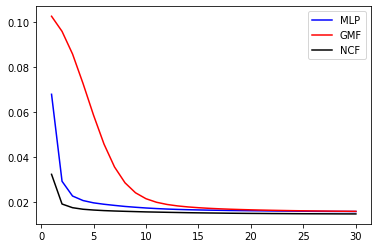

In [19]:
x_data = [n for n in range(1, 31)]
mlp, = plt.plot(x_data, MLP_Loss, color = 'blue')
gmf, = plt.plot(x_data, GMF_Loss, color = 'red')
ncf, = plt.plot(x_data, NCF_Loss, color = 'black')
plt.legend([mlp, gmf, ncf], ['MLP', 'GMF', 'NCF'])
plt.savefig("loss.jpg")
plt.show()

In [138]:
def metrics(net, test_data):
    recall, precise = [], []
    for user in test_data:
        all_items = torch.LongTensor([i for i in range(num_animes)]).cuda()
        test_user = torch.LongTensor([user for i in range(num_animes)]).cuda()
        pred = net(test_user, all_items)
        _, idx = torch.topk(pred, k = 100, dim = 0)
        
        target = [anime_to_idx[i] for i in ratings[ratings.user_id == user].anime_id.tolist()]
        idx = idx.cpu().numpy().flatten()
        overlap = list(set(target) & set(idx))
        recall.append(len(overlap) / len(target))
        precise.append(len(overlap) / len(idx))
        
    print(np.mean(recall), np.mean(precise))

In [12]:
torch.save(NCF_net.state_dict(), "NCF1.pt")
torch.save(GMF_net.state_dict(), "GMF1.pt")
torch.save(MLP_net.state_dict(), "MLP1.pt")

In [139]:
model = NCF(num_users, num_animes, model = 'NCF', GMF_model = GMF_net, MLP_model = MLP_net).cuda()
model.load_state_dict(torch.load("NCF.pt"))
metrics(model, test_data)

0.03497713525106813 0.1664543524416136
